<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

Use the model in repeatable conditions to estabish different patterns from operation

Load some representative wholesale power price data 

Establish some operational parameters and control strategies

Set a function to run the different strategies operating on the thermostat as this is all that the strategy can effectively control

In [ ]:
# Initialize an empty dictionary
strategies = {}

# Add some keys and values to the dictionary
# stategies[0] = 'description1'    
strategies[0] = {'name': 'Baseline case: current operation with ripple control',
                'operation': 'continuous',
                'bedrooms': 4,
                'element' :3,
                'Tset_H' : 60,
                'Tset_L' : 60,
                'radius' : 0.22,
                'height' : 1.1,
                'ripple' : True}
strategies[1] = {'name':'Baseline case: current operation with no ripple control',
            'operation': 'off_peak',
            'bedrooms': 4,
            'element' :3,
            'Tset_H' : 60,
            'Tset_L' : 60,
            'radius' : 0.22,
            'height' : 1.1,
            'ripple' : False}
strategies[2] = {'name': 'Split Control: remote operation on price signal with no ripple control',
            'operation': 'price',
            'bedrooms': 4,
            'element' :3,
            'Tset_H' : 75,
            'Tset_L' : 60,
                'radius' : 0.22,
                'height' : 1.1,
            'ripple' : False}
strategies[3] = {'name': 'Split Control: remote operation on price signal with no ripple control',
            'operation': 'price',
            'bedrooms': 4,
            'element' :3.6,
            'Tset_H' : 75,
            'Tset_L' : 60,
                'radius' : 0.3,
                'height' : 1.4,
            'ripple' : False}
strategies[4] = {'name': 'Split Control: remote operation on price signal with no ripple control',
            'operation': 'price',
            'bedrooms': 4,
            'element' :3,
            'Tset_H' : 70,
            'Tset_L' : 60,
                'radius' : 0.22,
                'height' : 1.1,
            'ripple' : False}

Add functionality for a thermostat

In [ ]:
df = {} 
time_period = '2020-06'
power = load_power(path = Path('../data/'), ripple_control=True)#/home/cjp/cylinder/data/powerprices.csv
for strategy in strategies:
    env = HWC(T_set=strategies[strategy]['Tset_H'], 
              radius=strategies[strategy]['radius'],
              height=strategies[strategy]['height'],
              element=strategies[strategy]['bedrooms'],
              U=.8)
    temp = []
    flow = load_demand(path = Path('../data/drawprofiles'),
                      bed=strategies[strategy]['bedrooms'],
                      unit=3).loc[:,'flow']
    for row in power.loc[time_period].itertuples(): # go through a set time period
        action = 0
        pwr = [1,1]
        
        # adjust for temperature
        env._thermostat()
        # establish if there is power going to the element based on the thermostat state and the strategy in relation to ripple control
        if env.thermostat[0] == 1: # if the thermostat high temperature sensor is on then need to look to the control strategy
            if strategies[strategy]['operation'] == 'off_peak': # if the strategy is to use the thermostat high temperature sensor then the element is on
                action = ~row.peak
            elif strategies[strategy]['operation'] == 'continuous': # if the strategy is to use the thermostat high temperature sensor then the element is on
                action = 1
            elif strategies[strategy]['operation'] == 'price': # if the strategy is to use the thermostat high temperature sensor then the element is on
                # action = 1 if row.cost < 0.1 else 0
                action = 1 if row.costrank_8h < 0.2 else 0

                pwr = [0,1]


        if env.thermostat[1] == 1: # if the thermostat base temperature sensor is on then the element is on
            action = 1
        

        if (strategies[strategy]['ripple']) & (row.ripple_control): # if ripple control is on then override the thermostat state
            action = 0
            pwr[1] = 0 # no power to the element

        env._update_model(action = action , flow = 2* flow.loc[row.Index]*60)
        temp.append([strategy,
                    action,
                    row.ripple_control * strategies[strategy]['ripple'] ,
                    *env.thermostat.copy(),
                    *env.temperatures.copy(),
                    env.z,
                    env.volume])
    tmp = pd.DataFrame(temp, 
                            columns=['strategy',
                                     'action',
                                     'ripple_control_demand',
                                     'thermostat_high',
                                     'thermostat_base',
                                     'T0',
                                     'T1',
                                     'z',
                                     'volume'])
    df[strategy] = pd.concat([power.loc[time_period].reset_index(),
                flow.loc[time_period].reset_index(drop=True),
                tmp.assign(energy = lambda df: df.volume.mean()*4.2*((df.T0*df.z + df.T1*(1-df.z))-55))],axis=1).set_index('timestamp')

/home/cjp/cylinder/cylinder/utils.py:37: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row in ser.iteritems():


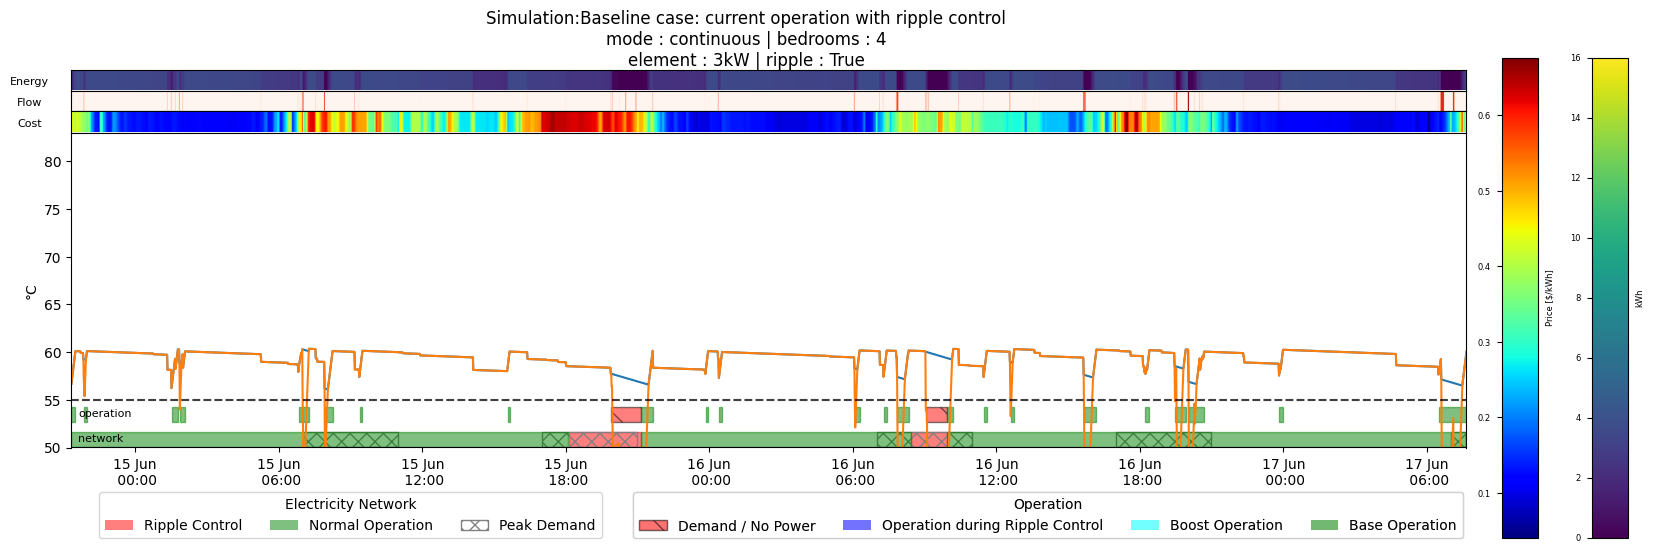

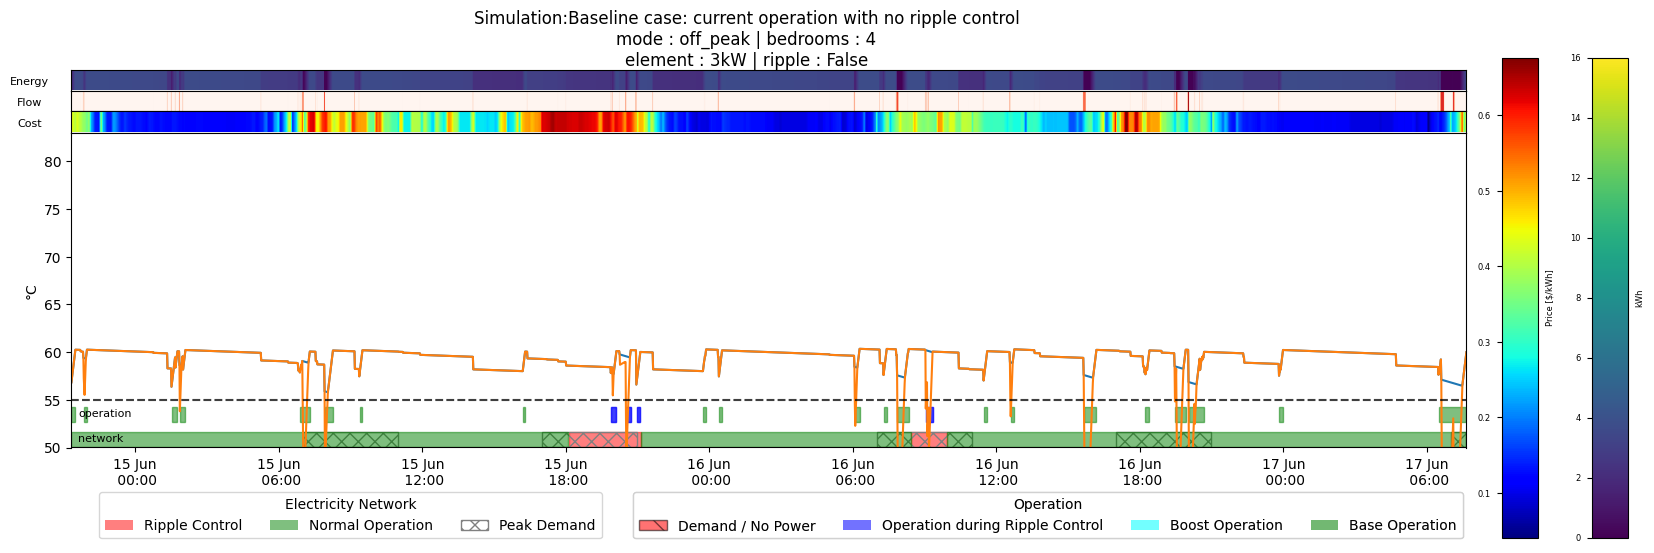

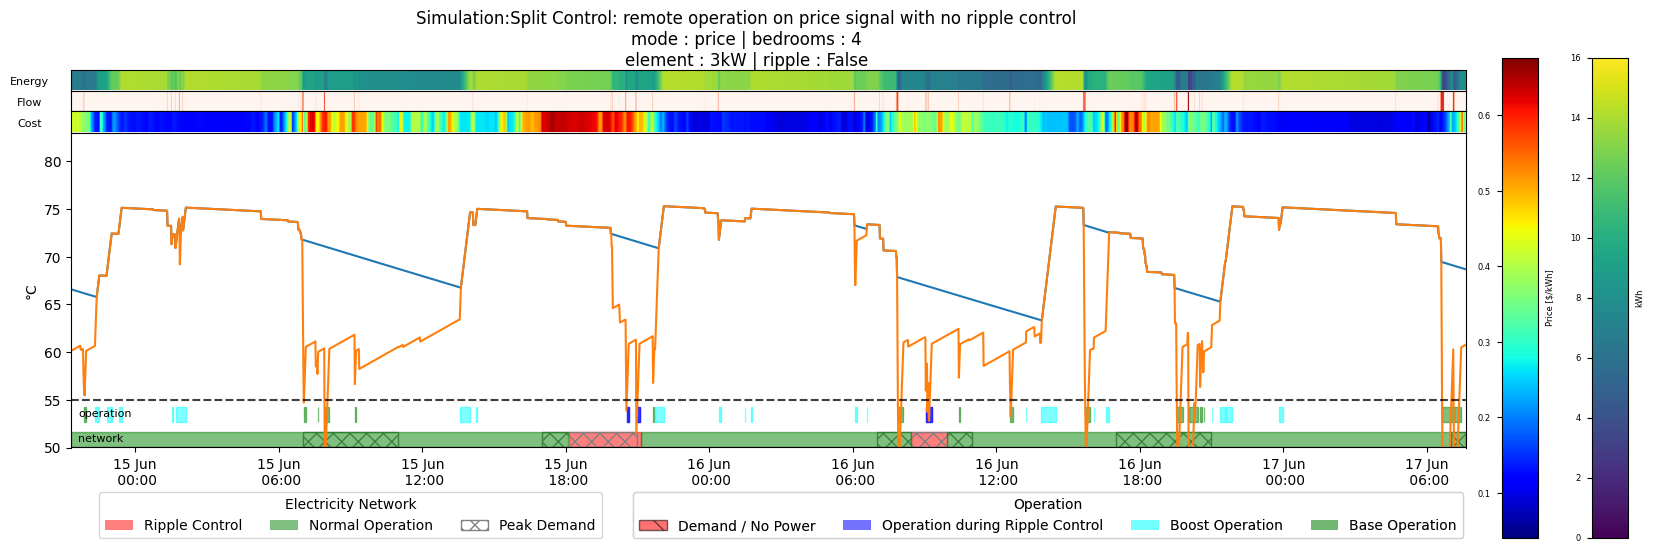

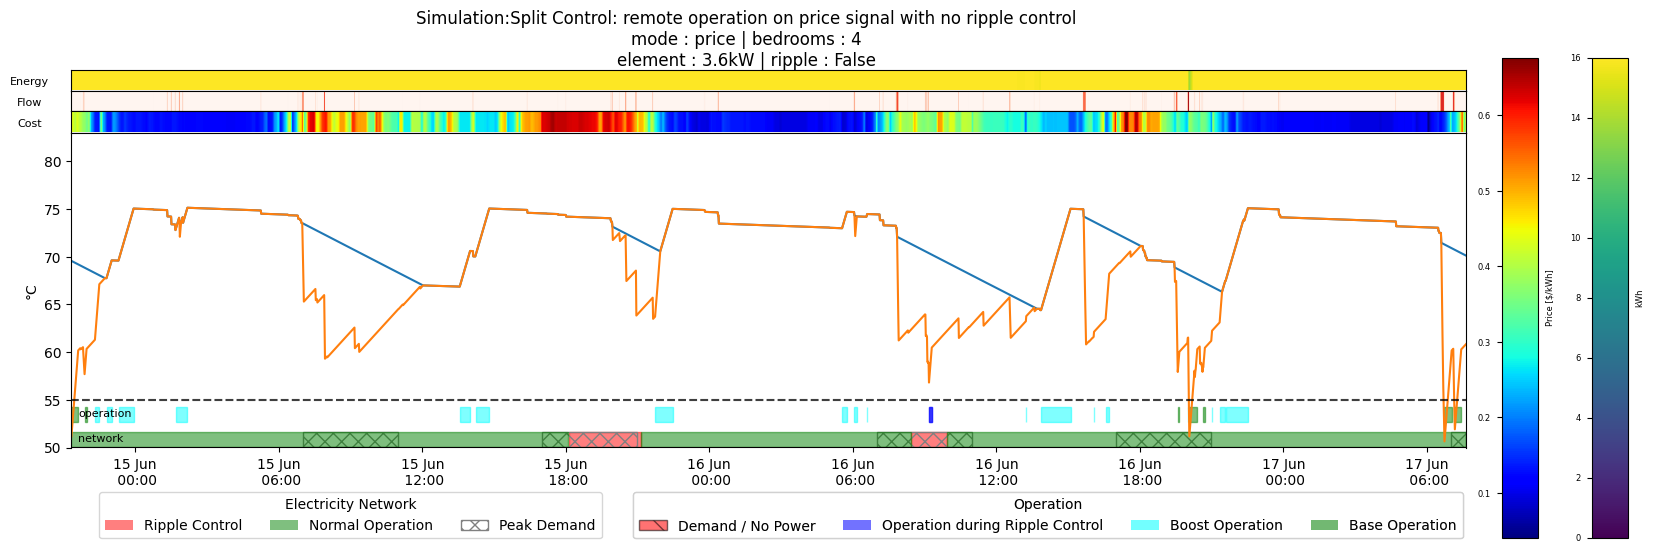

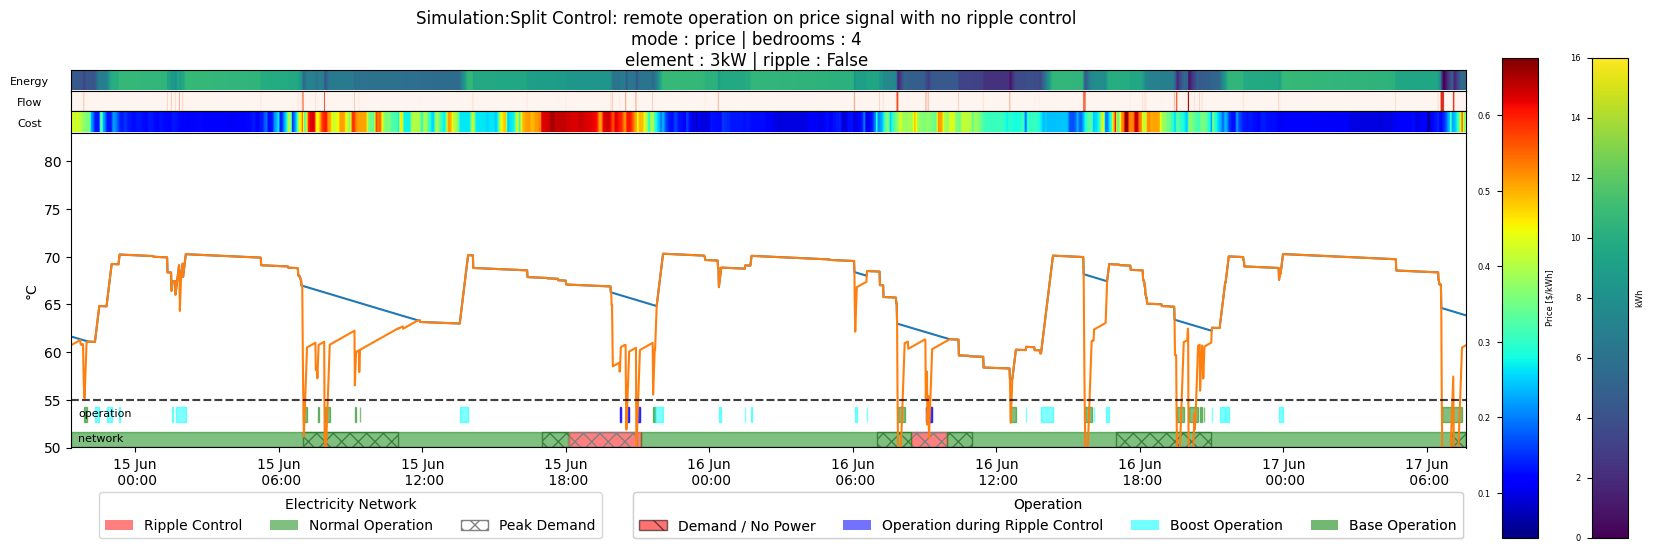

In [ ]:
for n in range(5):
    plot_sim(strategies[n], df[n].iloc[20000:23500])

In [ ]:
data = []
for n, sim in enumerate(df):
    t_mean = (0.7*df[n].T0.mean()+ 0.3*df[n].T1.mean())
    peak_demand = (df[n].peak*strategies[n]["element"]*df[n].action).sum()/len(df[n])
    # print(f'demand at peak : {100*peak_demand:.2f}%')
    local_kwh = (df[n].action*strategies[n]["element"]/60*df[n].thermostat_base*(df[n].ripple_control!=1)).sum()
    remote_kwh = (df[n].action*strategies[n]["element"]/60*df[n].thermostat_high*(df[n].thermostat_base!=1)).sum()
    # print(f'Local kWh : {local_kwh:.2f}',end=' ')
    # print(f'Remote kWh : {remote_kwh:.2f}')
    local_cost = (df[n].cost*strategies[n]["element"]/60*df[n].action*df[n].thermostat_base).sum()
    remote_cost = (df[n].cost*strategies[n]["element"]/60*df[n].action*df[n].thermostat_high*(df[n].thermostat_base!=1)).sum()
    # print(f'Local Cost : {local_cost/local_kwh:.2f}',end=' ')
    # print(f'Remote Cost : {remote_cost/remote_kwh:.2f}')

    loss_of_service = 100*(df[n].T0<55).sum()/len(df[n])
    days = (df[0].iloc[-1].name-df[0].iloc[0].name).days
    # print(f'Days : {days:.2f}')    
    # print(f'Loss of Service : {100*loss_of_service:.2f}%')    
    data.append([*strategies[n].values(),
                 df[n].iloc[0].name,
                 df[n].iloc[-1].name,
                 df[n].volume.mean()*1000,
                 peak_demand,
                 local_kwh,
                 remote_kwh,
                 local_kwh+remote_kwh,
                 local_cost,
                 remote_cost,
                 local_cost+remote_cost,
                 t_mean,
                 loss_of_service])
summary = pd.DataFrame(data,columns=list(strategies[0].keys())+['start_time', 'end_time', 'volume','peak_demand', 'local_kwh', 'remote_kwh', 'total_kwh', 'local_cost', 'remote_cost', 'total_cost', 't_mean', 'loss_of_service'])
summary['peak_reduction'] = 100*(summary.peak_demand-summary.loc[0,'peak_demand'])/summary.loc[0,'peak_demand']
summary['cost_reduction'] = 100*(summary.total_cost-summary.loc[0,'total_cost'])/summary.loc[0,'total_cost']

In [ ]:
summary.T

,0,1,2,3,4
name,Baseline case: current operation with ripple c...,Baseline case: current operation with no rippl...,Split Control: remote operation on price signa...,Split Control: remote operation on price signa...,Split Control: remote operation on price signa...
operation,continuous,off_peak,price,price,price
bedrooms,4,4,4,4,4
element,3.0,3.0,3.0,3.6,3.0
Tset_H,60,60,75,75,70
Tset_L,60,60,60,60,60
radius,0.22,0.22,0.22,0.3,0.22
height,1.1,1.1,1.1,1.4,1.1
ripple,True,False,False,False,False
start_time,2020-06-01 00:00:00,2020-06-01 00:00:00,2020-06-01 00:00:00,2020-06-01 00:00:00,2020-06-01 00:00:00
